In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from time import time
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr
from statsmodels.api import OLS
import seaborn as sns
import pickle
import sqlite3

In [2]:
def execute_query(query, retval=False):
    #create a database connection
    conn = sqlite3.connect('videos.db')

    #create a cursor
    cur = conn.cursor()
    
    cur.execute(query)
    result = cur.fetchall()

    #close connection
    conn.commit()
    conn.close()
    
    if retval:
        return result

In [3]:
def perform_adf_test(series):
    result = adfuller(series)
    return result[1]

In [4]:
def generate_time_series(num_series, series_length, max_orders, last_vals, second_last_vals):

    models = []
    num_stationary = 0
    
    #this matrix will contain all series
    series_data = np.empty((num_series, series_length))
    
    #this list will contain all coefs
    coefs_data = []
    
    #name of the orders
    order_names = ['p', 'q', 'r']
    
    #iterate over number of trials
    for idx in range(num_series):
        
        curr_orders = {name: 0 for name in order_names}
        while(sum(curr_orders.values()) == 0):
            #draw orders from the geometric distribution
            curr_orders = {name: min(max_orders[name], np.random.geometric(.5) - 1) for name in order_names}
                
        coefs_valid = False
        
        while(coefs_valid == False):
                
            #pick the coefficients
            curr_coefs = {'p': [], 'q': [], 'r': []}

            for order in order_names:
                #if it is the AR order, we need to specially sample from within simplex
                if order == 'p' and curr_orders['p'] > 0:
                    simplex_size = np.random.uniform(0,1)
                    breaks = np.random.uniform(0, simplex_size, curr_orders['p']-1)
                    breaks = np.sort(breaks)
                    breaks = np.insert(breaks, 0, 0)
                    breaks = np.insert(breaks, len(breaks), simplex_size)
                    coefs = np.diff(breaks)
                    coefs = coefs * (1 - 2*(np.random.uniform(0,1,len(coefs)) < .5))
                    curr_coefs[order] = coefs

                #otherwise just sample from normal distribution
                else:   
                    if curr_orders[order] > 0:
                        curr_coefs[order].extend([np.random.normal(0,1) for _ in range(2*curr_orders[order]-1)])
                    curr_coefs[order] = np.array(curr_coefs[order])

            #generate the data
            m = max(curr_orders.values())

            #initial values
            curr_ts = [np.random.normal() for _ in range(m)]
            for t in range(m+1, series_length+1):
                p_contrib = np.sum(curr_coefs['p'] * curr_ts[t-curr_orders['p']-1:t-1][::-1])
                q_contrib = np.sum(curr_coefs['q'] * last_vals[t-curr_orders['q']+1:t+curr_orders['q']][::-1])
                r_contrib = np.sum(curr_coefs['r'] * second_last_vals[t-curr_orders['r']:t+curr_orders['r']-1][::-1])
                

                curr_ts.append(p_contrib + q_contrib + r_contrib + np.random.normal(0,1))

            adf_p_val = perform_adf_test(curr_ts)

            acf_abs_diffs = np.diff(abs(acf(curr_ts)))
            diffs_sign = (acf_abs_diffs > 0)
            pct_same_diffs = np.mean(diffs_sign[1:] == diffs_sign[:-1])

            if adf_p_val < .05 and pct_same_diffs < 0.5:
                coefs_valid = True
         
        series_data[idx] = curr_ts
        coefs_data.append(curr_coefs)
          
    return {'series_data': series_data, 'coefs_data': coefs_data}

In [5]:
def fit_ols_model(df, test_size, orders, cols, metric_names=['aic', 'bic', 'ape'], plot=False):
    
    #get correction factor for aic
    k = orders[0] + sum([2*order-1 for order in orders[1:] if order > 0])
    n = len(df)
    aic_correction_factor = 2*k*(k+1) / (n-k-1)
    
    #one column for intercept
    num_feats = 1 + k
    
    #tells us number of data points we can use to fit
    start_idx = max(orders[0], orders[1]-1, orders[2]-1)
    end_idx = n - max(0, orders[1]-1, orders[2]-1)
    
    testing_indices = range(end_idx-test_size, end_idx)
    
    len_feat_mtx = len(df.iloc[start_idx:end_idx])
    
    #create feature matrix
    feats = np.empty((len_feat_mtx, num_feats))
    feats[:,0] = 1
    
    #the variable we are trying to model
    curr_series = df.iloc[start_idx:end_idx][cols[0]].to_numpy()
    
    #keeps track of the current column index
    curr_col_idx = 1
    
    #fill in the AR columns
    for idx in range(orders[0]):
        feats[:,curr_col_idx] = df[cols[0]].iloc[start_idx-idx-1:end_idx-idx-1]
        curr_col_idx += 1
    
    #iterate over each column
    for idx, col in enumerate(cols[1:]):
        #get the order
        order = orders[idx+1]
        #iterate over that order
        for idx in range(order-1,-order,-1):
            #perform the shift and store as a variable
            feats[:,curr_col_idx] = df[col].iloc[start_idx-idx:end_idx-idx]
            curr_col_idx += 1
            
    train_feats = feats[:-test_size]
    test_feats = feats[-test_size:]
    
    curr_series_train = curr_series[:-test_size]
    curr_series_test = curr_series[-test_size:]
    
    ape = None
    if 'ape' in metric_names:
        #calculate APE: maybe expensive
        ape = 0
        ape_range = range(5, len(train_feats), 5)
        pred_vals = []
        for limit in ape_range:
            model = OLS(curr_series[:limit], train_feats[:limit])
            model_fit = model.fit()
            pred_val = model_fit.predict(train_feats[limit])[0]
            diff = (pred_val - curr_series[limit])**2
            pred_vals.append(pred_val)
            ape += diff   
        ape = ape / len(ape_range)
    
    model = OLS(curr_series_train, train_feats)
    model_fit = model.fit()
    pred_obj = model_fit.get_prediction(test_feats)
    
    pred_means = pred_obj.predicted_mean
    dev_pred_means = pred_obj.var_pred_mean**.5
    
    if plot:
        print(start_idx, end_idx)
        print(len(train_feats))
        print(len(test_feats))
        plt.figure(figsize=(10,4))
        plt.plot(curr_series, color='b')
        plt.plot(range(len(curr_series_train), len(curr_series)), preds, color='r')
    
    ret_dict = {'aic': model_fit.aic + aic_correction_factor, 'bic': model_fit.bic, 'ape': ape, 'model': model_fit, 'preds': pred_means, 'pred_devs': dev_pred_means, 'testing_indices': testing_indices}
    return ret_dict

In [6]:
def store_model_info(results, best_models, name, orders):
    best_models[name]['value'] = results[name]
    best_models[name]['model'] = results['model']
    best_models[name]['orders'] = tuple(orders)
    best_models[name]['preds'] = results['preds']
    best_models[name]['pred_devs'] = results['pred_devs']
    best_models['testing_indices'] = results['testing_indices']
    return best_models

In [7]:
def model_space_search(possible_orders, df, max_iters, cols, test_size, metric_names=['aic', 'bic', 'ape']):
    
    #initialize best models
    best_models = {name: {'value': 9999999, 'model': None, 'orders': None, 'preds': None} for name in metric_names}
    
    #this will store all models seen so far
    checked_orders = set()
    
    #pick a starting point
    order_names = ['p', 'q', 'r']
    num_orders = len(order_names)
    orders = [np.random.choice(possible_orders[name]) for name in order_names]
    
    metric_name = metric_names[0]
    
    #for as many iterations as needed
    while len(checked_orders) < max_iters:
        
        #randomly decide to restart to explore more of model space
        if np.random.random() < .1:
            best_results = fit_ols_model(df, test_size, orders, cols, metric_names)
            if best_results[metric_name] < best_models[metric_name]['value']:
                best_models = store_model_info(best_results, best_models, metric_name, orders)
            orders = [np.random.choice(possible_orders[name]) for name in order_names]

        tup_orders = tuple(orders)
        
        #add this model order to the set
        checked_orders.add(tup_orders)
        
        #get all neighbors of current order
        p_neigh = [[orders[0]+diff, orders[1], orders[2]] for diff in [-1,1] if orders[0]+diff in possible_orders['p']]
        q_neigh = [[orders[0], orders[1]+diff, orders[2]] for diff in [-1,1] if orders[1]+diff in possible_orders['q']]
        r_neigh = [[orders[0], orders[1], orders[2]+diff] for diff in [-1,1] if orders[2]+diff in possible_orders['r']]
        all_neigh = p_neigh + q_neigh + r_neigh + [orders]
        all_neigh = [c for c in all_neigh if c != [0,0,0]]
        
        #run OLS for all neighbords, getting metric value each time
        local_metric_vals = []
        for neigh in all_neigh:
            try:
                results = fit_ols_model(df, test_size, neigh, cols, metric_names)
                curr_local_metric = results[metric_name]
                local_metric_vals.append(curr_local_metric)
            except:
                local_metric_vals.append(0)
            
        #sample from the neighbors by metric value
        probs = [-val for val in local_metric_vals]
        min_val, max_val = min(probs), max(probs)
        probs = [(val-min_val)/(max_val-min_val) for val in probs]
        tot = sum(probs)
        probs = np.array([val/tot for val in probs])
        probs[np.isnan(probs)] = 0
        if probs.sum() == 0:
            next_idx = np.random.choice(range(len(probs)))
        else:
            next_idx = np.random.choice(range(len(probs)), p=probs)
        
        orders = all_neigh[next_idx]
    
    best_results = fit_ols_model(df, test_size, orders, cols, metric_names)
    if best_results[metric_name] < best_models[metric_name]['value']:
        best_models = store_model_info(best_results, best_models, metric_name, orders)
    
    return best_models

In [8]:
def estimate_models(dataframes, max_iters, possible_orders, cols, test_size, metric_names=['aic', 'bic', 'ape']):
    
    data = []
    num_dfs = len(dataframes)

    start = time()
    
    for idx,df in enumerate(dataframes):
        if (idx+1) % 50 == 0:
            print('%s/%s'%((idx+1),num_dfs))
        
        result = model_space_search(possible_orders, df, max_iters, cols, test_size, metric_names)

        dict_results = {metric_name: result[metric_name] for metric_name in metric_names}
        dict_results['testing_indices'] = result['testing_indices']
        data.append(dict_results)
    
    end = time()
    
    print('Seconds:', end - start)
    
    return data

In [9]:
def orders_difference_first(t1, t2):
    return sum([abs(i-j) for i,j in zip(t1,t2)]) / len(t1)

In [10]:
def orders_difference_second(t1, t2):
    return sum([abs(i-j) > 1 for i,j in zip(t1,t2)]) / len(t1)

In [11]:
def reverse_stationarity_transformation(mu, sigma, pred_transf, lag_1_orig, lag_2_orig):
    
    const = np.exp(mu/sigma)
    
    return sigma*np.log(const*pred_transf + 2*np.exp(lag_1_orig/sigma) - np.exp(lag_2_orig/sigma))

In [12]:
def convert_transformed_predictions(df, col_name, model_estimation_result, test_size, plot=False):

    testing_indices = model_estimation_result['testing_indices']
    preds_transf = model_estimation_result['bic']['preds']
    
    pred_devs_transf = model_estimation_result['bic']['pred_devs']
    preds_transf_hi = preds_transf + pred_devs_transf
    preds_transf_lo = preds_transf - pred_devs_transf
    
    col_of_interest = df[col_name]

    mu, sigma = np.mean(col_of_interest), np.std(col_of_interest)

    preds = col_of_interest.iloc[testing_indices[0]-2:testing_indices[0]].values
    preds_hi = preds.copy()
    preds_lo = preds.copy()

    for idx in range(len(preds_transf)):
        preds = np.append(preds, reverse_stationarity_transformation(mu, sigma, preds_transf[idx], preds[-1], preds[-2]))
        preds_hi = np.append(preds_hi, reverse_stationarity_transformation(mu, sigma,  preds_transf_hi[idx], preds_hi[-1], preds_hi[-2]))
        preds_lo = np.append(preds_lo, reverse_stationarity_transformation(mu, sigma,  preds_transf_lo[idx], preds_lo[-1], preds_lo[-2]))
        
    preds = preds[-test_size:]
    preds_hi = preds_hi[-test_size:]
    preds_lo = preds_lo[-test_size:]

    true_vals = col_of_interest.iloc[testing_indices].values
    
    mape = np.mean(abs((true_vals-preds)/true_vals))
    
    if plot:
        plt.plot(preds, color='r')
        plt.plot(true_vals, color='b')
        plt.legend(['pred', 'true'], fontsize=16)
        plt.title('MAPE: %s%%'%round(mape*100,1), fontsize=20)
        
    
    return mape, true_vals, preds, preds_hi, preds_lo

# Testing

In [13]:
#last_vals = np.random.normal(0,1,10000)
#second_last_vals = np.random.normal(0,1,10000)

#series = generate_time_series(1000, 24*4, {'p': 6, 'q': 6, 'r':6}, last_vals, second_last_vals)

In [14]:
#col_names = ['curr', 'last', 'second']
#arrs = [np.stack([s, last_vals[:length], second_last_vals[:length]], axis=1) for s in series['series_data']]
#dataframes = [pd.DataFrame(arr, columns=col_names) for arr in arrs]

In [15]:
#data = estimate_models(dataframes, 150, {'p':list(range(7)), 'q': list(range(7)), 'r': list(range(7))}, col_names, 6)

In [16]:
#data_for_df = [[tuple([len(d[order]) for order in ['p','q','r']])] for d in series['coefs_data']]
#for idx, d in enumerate(data):
#    data_for_df[idx].extend([d['aic']['orders'], d['bic']['orders'], d['ape']['orders']])

In [17]:
#df_results = pd.DataFrame(columns=['generating_orders', 'aic_estimated_orders', 'bic_estimated_orders', 'ape_estimated_orders'], data=data_for_df)

In [18]:
#df_results['generating_num_params'] = df_results.generating_orders.apply(lambda x: sum(x))

#df_results['generating_aic_dist_first'] = df_results.apply(lambda row: orders_difference_first(row.generating_orders, row.aic_estimated_orders), 1)
#df_results['generating_bic_dist_first'] = df_results.apply(lambda row: orders_difference_first(row.generating_orders, row.bic_estimated_orders), 1)
#df_results['generating_ape_dist_first'] = df_results.apply(lambda row: orders_difference_first(row.generating_orders, row.ape_estimated_orders), 1)

#df_results['generating_aic_dist_second'] = df_results.apply(lambda row: orders_difference_second(row.generating_orders, row.aic_estimated_orders), 1)
#df_results['generating_bic_dist_second'] = df_results.apply(lambda row: orders_difference_second(row.generating_orders, row.bic_estimated_orders), 1)
#df_results['generating_ape_dist_second'] = df_results.apply(lambda row: orders_difference_second(row.generating_orders, row.ape_estimated_orders), 1)

In [19]:
#df_results.to_csv('model_meta_selection_results.csv', index=False)

In [20]:
#first_dist_avgs = df_results.groupby('generating_num_params').mean()[['generating_%s_dist_first'%metric for metric in ['aic','bic','ape']]]
#second_dist_avgs = df_results.groupby('generating_num_params').mean()[['generating_%s_dist_second'%metric for metric in ['aic','bic','ape']]]

In [21]:
# plt.figure(figsize=(10,4))
# l_aic, = plt.plot(first_dist_avgs.index, first_dist_avgs.generating_aic_dist_first, color='r')
# l_bic, = plt.plot(first_dist_avgs.index, first_dist_avgs.generating_bic_dist_first, color='b')
# l_ape, = plt.plot(first_dist_avgs.index, first_dist_avgs.generating_ape_dist_first, color='g')
# plt.legend(['AICc', 'BIC', 'APE'], fontsize=16)
# plt.xlabel('Number of Generating Paramters', fontsize=16)
# plt.ylabel('Avg $d_1$ values', fontsize=16)
# plt.xticks(first_dist_avgs.index, fontsize=14)
# plt.yticks(np.arange(1,4,.5), fontsize=14)
# plt.tight_layout()
# plt.savefig('d1_vals_model_meta_selection.png')

In [22]:
# plt.figure(figsize=(10,4))
# l_aic, = plt.plot(second_dist_avgs.index, second_dist_avgs.generating_aic_dist_second, color='r')
# l_bic, = plt.plot(second_dist_avgs.index, second_dist_avgs.generating_bic_dist_second, color='b')
# l_ape, = plt.plot(second_dist_avgs.index, second_dist_avgs.generating_ape_dist_second, color='g')
# plt.legend(['AICc', 'BIC', 'APE'], fontsize=16)
# plt.xlabel('Number of Generating Paramters', fontsize=16)
# plt.ylabel('Avg $d_2$ values', fontsize=16)
# plt.xticks(second_dist_avgs.index, fontsize=14)
# plt.yticks(np.arange(.2,1.1,.1), fontsize=14)
# plt.tight_layout()
# plt.savefig('d2_vals_model_meta_selection.png')

# On Real Data

In [39]:
data_dict = pickle.load(open("augmented_valid_dataframes_last_three_videos.p", "rb"))

In [37]:
existing_vid_ids = dfs[6].video_id.values

In [38]:
real_col_names = ['views_transformed', 'views_last_transformed', 'views_second_transformed']
num_channels = len(data_dict)

for test_size in [6, 12, 18, 24, 48]:
    print('====================')
    print(test_size)
    print('====================')
    count = 1

    real_model_fitting_data = []

    for uploads_id, vid_id_to_df in data_dict.items():
        print('%s/%s'%(count, num_channels))
        print(uploads_id)
        count += 1

        vid_ids_and_dfs = [(vid_id, df) for vid_id,df in vid_id_to_df.items()]
        vid_ids = [item[0] for item in vid_ids_and_dfs if item[0] not in existing_vid_ids]
        dfs = [item[1].dropna().reset_index() for item in vid_ids_and_dfs if item[0] not in existing_vid_ids]
        results = estimate_models(dfs, 50, {'p':list(range(7)), 'q': list(range(7)), 'r': list(range(7))}, real_col_names, test_size, ['bic'])

        for vid_id, df, result in zip(vid_ids, dfs, results):
            mape, true_vals, preds, preds_hi, preds_lo = convert_transformed_predictions(df, 'views', result, test_size, False)
            real_model_fitting_data.append([vid_id, uploads_id, result['bic']['model'], result['bic']['orders'], mape, true_vals, preds, preds_hi, preds_lo])

        pickle.dump(real_model_fitting_data, open("augmented_real_model_fitting_data_test_size_%s.p"%test_size, "wb"))
        print('----------')
        
    df_real_model_fitting = pd.DataFrame(columns=['video_id', 'uploads_id', 'model', 'estimated_orders', 'mape', 'true_vals', 'preds', 'hi', 'lo'], data=real_model_fitting_data)
    pickle.dump(df_real_model_fitting, open("augmented_real_model_fitting_df_test_size_%s.p"%test_size, "wb"))

6
1/104
UU1zZE_kJ8rQHgLTVfobLi_g
Seconds: 35.693528175354004
----------
2/104
UUJFp8uSYCjXOMnkUyb3CQ3Q
Seconds: 64.74499034881592
----------
3/104
UUUcpVoi5KkJmnE3bvEhHR0Q
Seconds: 0.0
----------
4/104
UUq-Fj5jknLsUf-MWSy4_brA
Seconds: 45.60008502006531
----------
5/104
UUJHA_jMfCvEnv-3kRjTCQXw
Seconds: 6.274235248565674
----------
6/104
UUoxcjq-8xIDTYp3uz647V5A
Seconds: 0.0
----------
7/104
UUphTF9wHwhCt-BzIq-s4V-g
Seconds: 6.750934839248657
----------
8/104
UUYxRlFDqcWM4y7FfpiAN3KQ
Seconds: 24.228237628936768
----------
9/104
UUcjhYlL1WRBjKaJsMH_h7Lg
Seconds: 2.1741788387298584
----------
10/104
UUPNxhDvTcytIdvwXWAm43cA
Seconds: 0.0
----------
11/104
UULA_DiR1FfKNvjuUpBHmylQ
Seconds: 46.053956747055054
----------
12/104
UUbpMy0Fg74eXXkvxJrtEn3w
Seconds: 0.0
----------
13/104
UU4tAgeVdaNB5vD_mBoxg50w
Seconds: 51.23811602592468
----------
14/104
UURijo3ddMTht_IHyNSNXpNQ
Seconds: 2.3278305530548096
----------
15/104
UUX6OQ3DkcsbYNE6H8uQQuVA
Seconds: 0.0
----------
16/104
UUhGJGhZ9SOOHvB

C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


Seconds: 80.96398425102234
----------
82/104
UUI4I6ldZ0jWe7vXpUVeVcpg
Seconds: 0.0
----------
83/104
UU6x7GwJxuoABSosgVXDYtTw
Seconds: 0.0
----------
84/104
UUWwqHwqLSrdWMgp5DZG5Dzg
Seconds: 5.811182022094727
----------
85/104
UUUQo7nzH1sXVpzL92VesANw
Seconds: 0.0
----------
86/104
UUap97Ue8K_BpKlrvQRYd6JA
Seconds: 0.0
----------
87/104
UUTTJMptGhfJA67e40DlqbNw
Seconds: 3.9081761837005615
----------
88/104
UUF5UrKfIq5ap9skGOgm4W7w
Seconds: 0.0
----------
89/104
UUVrvnobbNGGMsS5n2mJwfOg
Seconds: 0.0
----------
90/104
UU_hoQDD6zKcIqpIYLsFbBeA
Seconds: 2.2579855918884277
----------
91/104
UUDLmS9vkPcTz3cAc-c9QIzg
Seconds: 0.0
----------
92/104
UUctXZhXmG-kf3tlIXgVZUlw
Seconds: 9.27026915550232
----------
93/104
UUvVuqRzGVqRlmZYlTf99M_w
Seconds: 0.0
----------
94/104
UUGaVdbSav8xWuFWTadK6loA
Seconds: 0.0
----------
95/104
UUrUbqTCagwsaP2Fmr0p1TsA
Seconds: 0.0
----------
96/104
UUVsTboAhpnuL6j-tDePvNwQ
Seconds: 0.0
----------
97/104
UUgWfS_47YPVbKx5EK4FLm4A
Seconds: 0.0
----------
98/104
UU

C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


----------
27/104
UU2iUwfYi_1FCGGqhOUNx-iA
Seconds: 78.51614761352539
----------
28/104
UUvC4D8onUfXzvjTOM-dBfEA
Seconds: 24.42173433303833
----------
29/104
UUz97F7dMxBNOfGYu3rx8aCw
Seconds: 0.0
----------
30/104
UUY30JRSgfhYXA6i6xX1erWg
Seconds: 3.546562433242798
----------
31/104
UU9gFih9rw0zNCK3ZtoKQQyA
Seconds: 0.0
----------
32/104
UUfm4y4rHF5HGrSr-qbvOwOg
Seconds: 3.1894805431365967
----------
33/104
UUPDXXXJj9nax0fr0Wfc048g
Seconds: 2.1442711353302
----------
34/104
UUa90xqK2odw1KV5wHU9WRhg
Seconds: 2.3108229637145996
----------
35/104
UUcgqSM4YEo5vVQpqwN-MaNw
Seconds: 0.0
----------
36/104
UUYvmuw-JtVrTZQ-7Y4kd63Q
Seconds: 0.0
----------
37/104
UU0C-w0YjGpqDXGB8IHb662A
Seconds: 0.0
----------
38/104
UUqECaJ8Gagnn7YCbPEzWH6g
Seconds: 0.0
----------
39/104
UUfM3zsQsOnfWNUppiycmBuw
Seconds: 0.0
----------
40/104
UUEdvpU2pFRCVqU6yIPyTpMQ
Seconds: 2.7885522842407227
----------
41/104
UUIwFjwMjI0y7PDBVEO9-bkQ
Seconds: 0.0
----------
42/104
UUOmHUn--16B90oW2L6FRR3A
Seconds: 2.7477116

----------
52/104
UUHnyfMqiRRG1u-2MsSQLbXA
Seconds: 0.0
----------
53/104
UUpGdL9Sn3Q5YWUH2DVUW1Ug
Seconds: 3.006023406982422
----------
54/104
UU8rNKrqBxJqL9izOOMxBJtw
Seconds: 69.10131859779358
----------
55/104
UUAW-NpUFkMyCNrvRSSGIvDQ
Seconds: 35.68966865539551
----------
56/104
UUIPA6iWNaoetaa1T46RkzXw
Seconds: 69.36660480499268
----------
57/104
UUYzPXprvl5Y-Sf0g4vX-m6g
Seconds: 53.127042055130005
----------
58/104
UUKqH_9mk1waLgBiL2vT5b9g
Seconds: 3.976424217224121
----------
59/104
UU7_YxT-KID8kRbqZo7MyscQ
Seconds: 1.8331515789031982
----------
60/104
UUam8T03EOFBsNdR0thrFHdQ
Seconds: 64.74102234840393
----------
61/104
UUS5Oz6CHmeoF7vSad0qqXfw
Seconds: 2.781571626663208
----------
62/104
UUBnZ16ahKA2DZ_T5W0FPUXg
Seconds: 8.274845838546753
----------
63/104
UU_8PAD0Qmi6_gpe77S1Atgg
Seconds: 9.26429796218872
----------
64/104
UUJplp5SjeGSdVdwsfb9Q7lQ
Seconds: 12.000929832458496
----------
65/104
UUBAb_DK4GYZqZR9MFA7y2Xg
Seconds: 0.0
----------
66/104
UUsPF3cApzCohxPp5oKdoWSQ
Sec

Seconds: 10.311451196670532
----------
76/104
UUiWLfSweyRNmLpgEHekhoAg
Seconds: 0.0
----------
77/104
UUWJ2lWNubArHWmf3FIHbfcQ
Seconds: 0.0
----------
78/104
UUqFMzb-4AUf6WAIbl132QKA
Seconds: 20.34867787361145
----------
79/104
UUttspZesZIDEwwpVIgoZtWQ
Seconds: 0.0
----------
80/104
UUzNAswnSN0rZy79clU-DRPg
Seconds: 6.809807062149048
----------
81/104
UUhtY6O8Ahw2cz05PS2GhUbg
Seconds: 70.40682005882263
----------
82/104
UUI4I6ldZ0jWe7vXpUVeVcpg
Seconds: 0.0
----------
83/104
UU6x7GwJxuoABSosgVXDYtTw
Seconds: 0.0
----------
84/104
UUWwqHwqLSrdWMgp5DZG5Dzg
Seconds: 5.470383167266846
----------
85/104
UUUQo7nzH1sXVpzL92VesANw
Seconds: 0.0
----------
86/104
UUap97Ue8K_BpKlrvQRYd6JA
Seconds: 0.0
----------
87/104
UUTTJMptGhfJA67e40DlqbNw
Seconds: 4.661543607711792
----------
88/104
UUF5UrKfIq5ap9skGOgm4W7w
Seconds: 0.0
----------
89/104
UUVrvnobbNGGMsS5n2mJwfOg
Seconds: 0.0
----------
90/104
UU_hoQDD6zKcIqpIYLsFbBeA
Seconds: 2.0774545669555664
----------
91/104
UUDLmS9vkPcTz3cAc-c9QIzg
Seco

C:\Users\ritvik\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1620: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


Seconds: 41.06325316429138
----------
2/104
UUJFp8uSYCjXOMnkUyb3CQ3Q
Seconds: 66.18361043930054
----------
3/104
UUUcpVoi5KkJmnE3bvEhHR0Q
Seconds: 0.0
----------
4/104
UUq-Fj5jknLsUf-MWSy4_brA
Seconds: 39.58415484428406
----------
5/104
UUJHA_jMfCvEnv-3kRjTCQXw
Seconds: 6.335124492645264
----------
6/104
UUoxcjq-8xIDTYp3uz647V5A
Seconds: 0.0
----------
7/104
UUphTF9wHwhCt-BzIq-s4V-g
Seconds: 7.01324200630188
----------
8/104
UUYxRlFDqcWM4y7FfpiAN3KQ
Seconds: 28.249481678009033
----------
9/104
UUcjhYlL1WRBjKaJsMH_h7Lg
Seconds: 2.7965822219848633
----------
10/104
UUPNxhDvTcytIdvwXWAm43cA
Seconds: 0.0
----------
11/104
UULA_DiR1FfKNvjuUpBHmylQ


C:\Users\ritvik\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:889: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


Seconds: 44.11222553253174
----------
12/104
UUbpMy0Fg74eXXkvxJrtEn3w
Seconds: 0.0


C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


----------
13/104
UU4tAgeVdaNB5vD_mBoxg50w
Seconds: 52.09277391433716
----------
14/104
UURijo3ddMTht_IHyNSNXpNQ
Seconds: 1.9896814823150635
----------
15/104
UUX6OQ3DkcsbYNE6H8uQQuVA
Seconds: 0.0
----------
16/104
UUhGJGhZ9SOOHvBB0Y4DOO_w
Seconds: 0.0
----------
17/104
UU295-Dw_tDNtZXFeAPAW6Aw
Seconds: 0.0
----------
18/104
UU9CoOnJkIBMdeijd9qYoT_g
Seconds: 0.0
----------
19/104
UURIZtPl9nb9RiXc9btSTQNw
Seconds: 2.2210640907287598
----------
20/104
UUIEv3lZ_tNXHzL3ox-_uUGQ
Seconds: 0.0
----------
21/104
UUNbngWUqL2eqRw12yAwcICg
Seconds: 8.566110610961914
----------
22/104
UU8gFadPgK2r1ndqLI04Xvvw
Seconds: 2.18221378326416
----------
23/104
UUpSgg_ECBj25s9moCDfSTsA
Seconds: 5.940125942230225
----------
24/104
UUYjk_zY-iYR8YNfJmuzd70A
Seconds: 0.0
----------
25/104
UUpko_-a4wgz2u_DgDgd9fqA
Seconds: 71.65054035186768
----------
26/104
UUSAUGyc_xA8uYzaIVG6MESQ
Seconds: 0.0
----------
27/104
UU2iUwfYi_1FCGGqhOUNx-iA
Seconds: 73.01953125
----------
28/104
UUvC4D8onUfXzvjTOM-dBfEA
Seconds: 2

# Error Analysis

## MAPE by Num Days Predicted

In [7]:
test_horizons = [6,12,18,24,48]

In [8]:
dfs = {}
aug_dfs = {}
avg_mapes = []
dev_mapes = []

for s in test_horizons:
    dfs[s] = pickle.load(open("real_model_fitting_df_test_size_%s.p"%s, "rb"))
    aug_dfs[s] = pickle.load(open("augmented_real_model_fitting_df_test_size_%s.p"%s, "rb"))
    dfs[s] = pd.concat([dfs[s], aug_dfs[s]])
    avg_mapes.append(dfs[s].mape[:6].mean())
    dev_mapes.append(dfs[s].mape[:6].std())

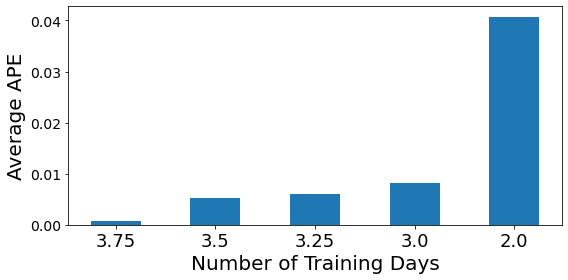

In [9]:
plt.figure(figsize=(8,4))
tr_days = [4-i/24 for i in test_horizons]
plt.bar(range(len(test_horizons)), avg_mapes, width=1/2)
plt.xticks(range(len(test_horizons)), tr_days, fontsize=18)
plt.yticks(np.arange(0,.05,.01), fontsize=14)
plt.xlabel('Number of Training Days', fontsize=20)
plt.ylabel('Average APE', fontsize=20)

plt.tight_layout() 

plt.savefig('avg_ape_by_training_days.png')

## MAPE by training length

In [10]:
avg_ape_dict = {}
dev_ape_dict = {}

#for each training period
for s in test_horizons:
    #get the average percent error for each video
    apes = dfs[s].apply(lambda row: abs((row.preds-row.true_vals) / row.true_vals), 1)
    
    #initialize
    avg_apes, dev_apes = [], []
    
    #for each testing hour
    for i in range(s):
        #get the average percent error for the ith testing hour
        lim = apes.apply(lambda x: x[i])
        
        #take the avg and dev
        avg_apes.append(lim.mean())
        dev_apes.append(lim.std())
    
    avg_ape_dict[s] = avg_apes
    dev_ape_dict[s] = dev_apes

C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


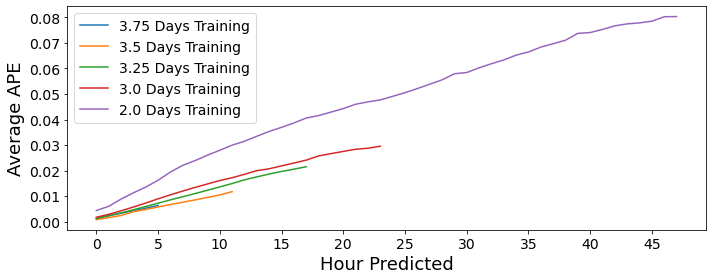

In [11]:
plt.figure(figsize=(10,4))

for s in test_horizons:
    
    #plot the average ape
    plt.plot(avg_ape_dict[s])

plt.legend(['%s Days Training'%t for t in tr_days], fontsize=14)
plt.xlabel('Hour Predicted', fontsize=18)
plt.ylabel('Average APE', fontsize=18)
plt.xticks(np.arange(0,50,5), fontsize=14)
plt.yticks(np.arange(0,.09,.01), fontsize=14)

plt.tight_layout() 

plt.savefig('avg_ape_by_testing_horizon.png')

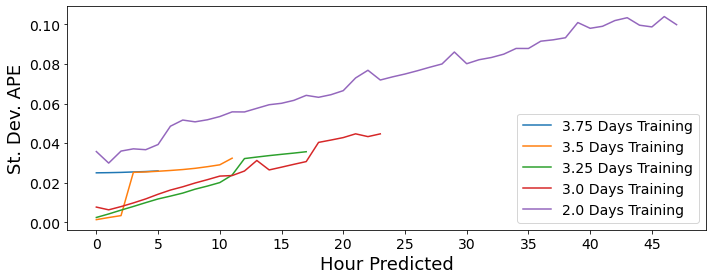

In [12]:
plt.figure(figsize=(10,4))

for s in test_horizons:
    
    #plot the average ape
    plt.plot(dev_ape_dict[s])

plt.legend(['%s Days Training'%t for t in tr_days], fontsize=14)
plt.xlabel('Hour Predicted', fontsize=18)
plt.ylabel('St. Dev. APE', fontsize=18)
plt.xticks(np.arange(0,50,5), fontsize=14)
plt.yticks(np.arange(0,.12,.02), fontsize=14)

plt.tight_layout() 

plt.savefig('dev_ape_by_testing_horizon.png')

In [13]:
channel_id_to_area = dict(execute_query('SELECT ChannelID, Area FROM Channels', True))

In [14]:
for s in test_horizons:
    dfs[s]['area'] = dfs[s].uploads_id.apply(lambda x: channel_id_to_area[x[0] + 'C' + x[2:]])

C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


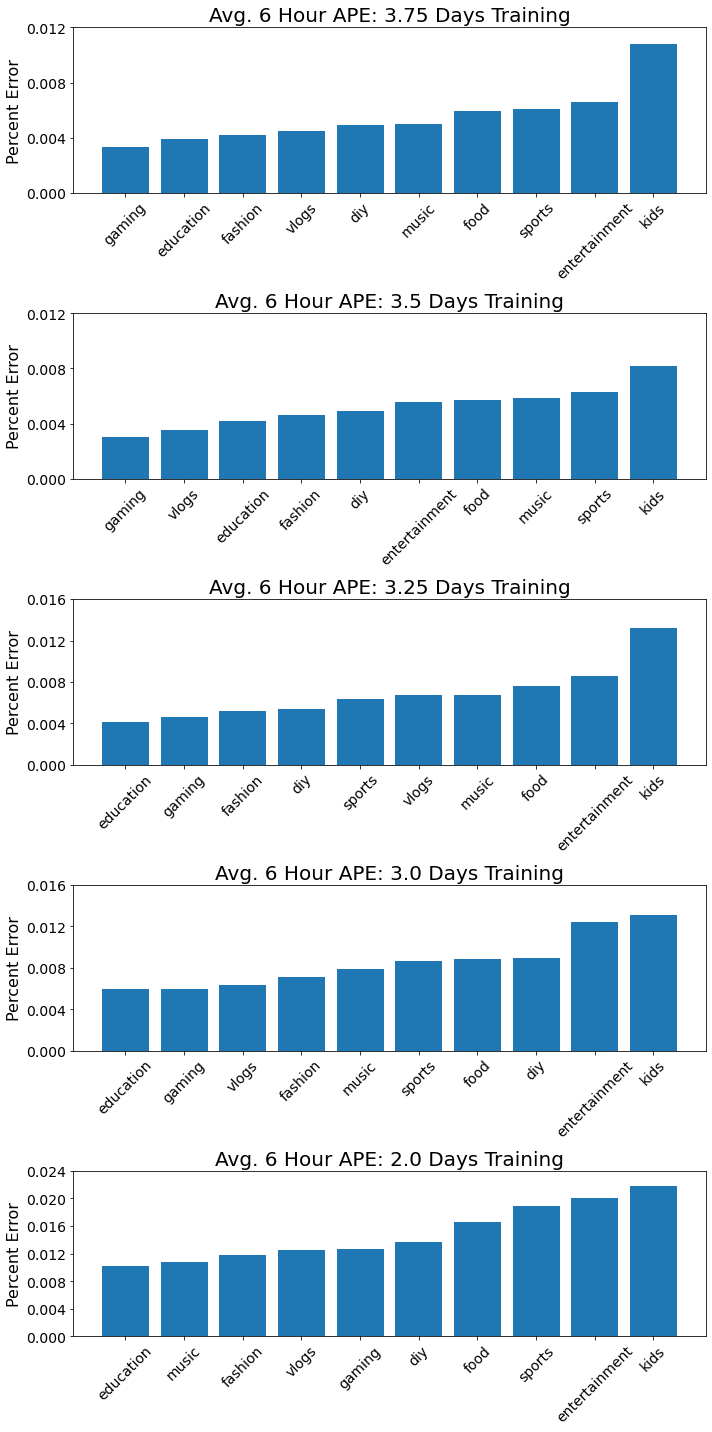

In [15]:
plt.figure(figsize=(10,20))
i = 1
for s in test_horizons:
    apes_6 = dfs[s].apply(lambda row: abs((row.preds[5]-row.true_vals[5]) / row.true_vals[5]), 1)
    dfs[s]['ape_6'] = apes_6
    ape_6_by_area = dfs[s].groupby('area').mean().ape_6.sort_values()
    plt.subplot(5,1,i)
    plt.bar(ape_6_by_area.index, ape_6_by_area.values)
    plt.xticks(ape_6_by_area.index, fontsize=14, rotation=45)
    plt.yticks(np.arange(0,ape_6_by_area.max()+.004,.004), fontsize=14)
    plt.title('Avg. 6 Hour APE: %s Days Training'%(4-s/24), fontsize=20)
    plt.ylabel('Percent Error', fontsize=16)
       
    i += 1
    
plt.tight_layout() 
    
plt.savefig('six_hour_ape_error_by_area.png')

In [16]:
dfs[6].groupby('area').count().mape.sort_values()

area
music             54
vlogs             80
sports            88
education         90
fashion          139
diy              157
entertainment    185
kids             195
food             206
gaming           308
Name: mape, dtype: int64

In [17]:
dfs[6].groupby('area').apply(lambda df: len(set(df.uploads_id))).sort_values()

area
music             3
education         5
sports            7
vlogs             7
fashion           8
kids              8
diy               9
entertainment     9
gaming            9
food             11
dtype: int64

In [18]:
orders_freq = dict()
for order in dfs[6].estimated_orders:
    if order in orders_freq:
        orders_freq[order] += 1
    else:
        orders_freq[order] = 1

In [19]:
sorted(orders_freq.items(), key=lambda x: -x[1])[:10]

[((1, 0, 0), 315),
 ((1, 0, 1), 176),
 ((1, 1, 0), 165),
 ((0, 1, 0), 138),
 ((0, 0, 1), 128),
 ((0, 1, 1), 106),
 ((1, 1, 1), 91),
 ((2, 0, 0), 49),
 ((1, 2, 0), 35),
 ((1, 0, 2), 33)]

In [20]:
sorted(orders_freq.items(), key=lambda x: -x[1])[-10:]

[((2, 2, 1), 1),
 ((2, 5, 1), 1),
 ((0, 5, 3), 1),
 ((3, 0, 2), 1),
 ((3, 2, 3), 1),
 ((2, 3, 2), 1),
 ((0, 2, 3), 1),
 ((0, 2, 4), 1),
 ((1, 4, 3), 1),
 ((3, 2, 4), 1)]

# Prediction Graphs

In [27]:
execute_query('SELECT UploadsID FROM Channels WHERE Title="Tasty"', True)[0][0]

'UUJFp8uSYCjXOMnkUyb3CQ3Q'

In [28]:
df = dfs[48]

In [30]:
df[df.uploads_id == 'UUJFp8uSYCjXOMnkUyb3CQ3Q'].sort_values('mape')

,video_id,uploads_id,model,estimated_orders,mape,true_vals,preds,hi,lo,area,ape_6
26,uzVqMcK67DI,UUJFp8uSYCjXOMnkUyb3CQ3Q,<statsmodels.regression.linear_model.Regressio...,"(2, 3, 2)",0.006690,"[188425.0, 190776.0, 192793.0, 194683.0, 19603...","[187949.6736801046, 189096.3843755968, 189952....","[188126.3496162728, 189632.622922103, 191027.6...","[187772.4174327887, 188554.76389607487, 188856...",food,0.017793
29,RLNkCcnTPYM,UUJFp8uSYCjXOMnkUyb3CQ3Q,<statsmodels.regression.linear_model.Regressio...,"(1, 0, 1)",0.006810,"[114161.0, 114996.0, 115870.0, 116544.0, 11702...","[113993.873896788, 114715.21465965406, 115639....","[114038.18775447275, 114847.92072191328, 11592...","[113949.49355990962, 114581.91061232825, 11535...",food,0.002282
30,girpGVZ1U3o,UUJFp8uSYCjXOMnkUyb3CQ3Q,<statsmodels.regression.linear_model.Regressio...,"(1, 0, 0)",0.007220,"[84707.0, 85810.0, 86650.0, 87575.0, 88172.0, ...","[84559.3606222696, 85245.3405307623, 85766.568...","[84592.05587661419, 85329.92260192758, 85938.0...","[84526.62046330929, 85160.45727955452, 85593.8...",food,0.010840
35,826q8ySWZus,UUJFp8uSYCjXOMnkUyb3CQ3Q,<statsmodels.regression.linear_model.Regressio...,"(0, 1, 1)",0.009842,"[255947.0, 257865.0, 260174.0, 262602.0, 26492...","[255062.5957279336, 257208.04904104475, 259073...","[255180.56326707997, 257600.10361343983, 25995...","[254944.42856594853, 256813.78091456398, 25817...",food,0.006120
23,K6tcjjSo9_g,UUJFp8uSYCjXOMnkUyb3CQ3Q,<statsmodels.regression.linear_model.Regressio...,"(0, 0, 1)",0.009997,"[261914.0, 265319.0, 271031.0, 273798.0, 27710...","[261845.48121000128, 264930.60365942196, 26798...","[261932.3646053156, 265181.0456388192, 268469....","[261758.51673877073, 264679.4868469371, 267493...",food,0.013691
36,mMaK2p9-8_Y,UUJFp8uSYCjXOMnkUyb3CQ3Q,<statsmodels.regression.linear_model.Regressio...,"(2, 3, 1)",0.010497,"[75554.0, 76149.0, 76454.5, 76760.0, 77313.0, ...","[75601.58287476124, 76358.21922302175, 76772.9...","[75645.2689908921, 76485.9886705569, 77029.399...","[75557.78501878385, 76229.48922464187, 76512.5...",food,0.010370
33,qEeIlIhHV2A,UUJFp8uSYCjXOMnkUyb3CQ3Q,<statsmodels.regression.linear_model.Regressio...,"(1, 0, 0)",0.010998,"[269862.0, 272365.0, 275548.0, 276868.0, 27941...","[270051.48033987934, 271648.22829053993, 27283...","[270204.67845792545, 272073.5996609123, 273693...","[269897.8734836656, 271219.69070760213, 271953...",food,0.020205
32,FskyhRKtevg,UUJFp8uSYCjXOMnkUyb3CQ3Q,<statsmodels.regression.linear_model.Regressio...,"(1, 0, 2)",0.012430,"[165140.0, 165752.0, 166383.0, 167192.0, 16802...","[165352.64972232137, 166289.8697421883, 167259...","[165408.136975267, 166466.55651533604, 167610....","[165297.0797877102, 166112.3418694323, 166905....",food,0.009683
25,63nD0oPjQTo,UUJFp8uSYCjXOMnkUyb3CQ3Q,<statsmodels.regression.linear_model.Regressio...,"(1, 1, 2)",0.012958,"[99028.0, 99847.0, 100694.0, 101453.0, 102203....","[98951.45942631745, 99631.03510135066, 100254....","[99021.75425878853, 99838.260205471, 100623.98...","[98880.94417052345, 99421.88265372728, 99878.6...",food,0.006301
43,fsf6V2ciuqE,UUJFp8uSYCjXOMnkUyb3CQ3Q,<statsmodels.regression.linear_model.Regressio...,"(0, 1, 1)",0.014629,"[44220.0, 44256.0, 44600.0, 44983.0, 45325.0, ...","[44206.03527756321, 44292.4949936598, 44634.13...","[44230.556127030206, 44358.39990939547, 44765....","[44181.450966270146, 44226.12963076055, 44501....",food,0.002271


In [141]:
vid_id = 'RLNkCcnTPYM'
orig_views = data_dict['UUJFp8uSYCjXOMnkUyb3CQ3Q'][vid_id].iloc[:95].views

In [144]:
offset = 0

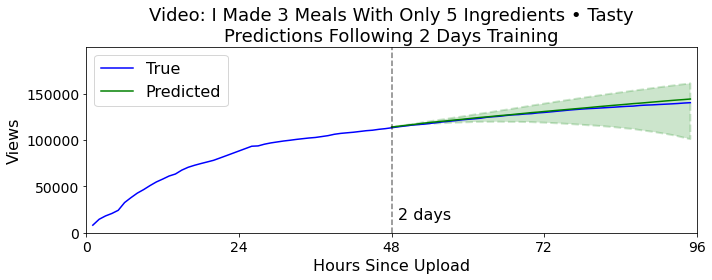

In [148]:
data = df[df.video_id == vid_id].iloc[0]

plt.figure(figsize=(10,4))

plt.plot(np.arange(1,len(orig_views)+1), orig_views, color='b')

#plt.plot(np.arange(48,48+48), data.true_vals+offset, color='b')
plt.plot(np.arange(48,48+48), data.preds+offset, color='g')
plt.fill_between(np.arange(48,48+48), data.lo+offset, data.hi+offset, color='g', alpha=0.2, linestyle='--', linewidth=2)
plt.xlim(0,96)
plt.yticks(np.arange(0,200000,50000), fontsize=14)
plt.ylim(0, 200000)
plt.xticks(np.arange(0,100,24), fontsize=14)

plt.xlabel('Hours Since Upload', fontsize=16)
plt.ylabel('Views', fontsize=16)

plt.legend(['True', 'Predicted'], fontsize=16, loc=2)

plt.title('Video: I Made 3 Meals With Only 5 Ingredients • Tasty\nPredictions Following 2 Days Training', fontsize=18)

plt.axvline(48, color='k', linestyle='--', alpha=0.5)
plt.annotate('2 days', (49,15000), fontsize=16)

plt.tight_layout()
plt.savefig('pred_and_true_views_tasty.png')

In [149]:
data

video_id                                                  RLNkCcnTPYM
uploads_id                                   UUJFp8uSYCjXOMnkUyb3CQ3Q
model               <statsmodels.regression.linear_model.Regressio...
estimated_orders                                            (1, 0, 1)
mape                                                       0.00681018
true_vals           [114161.0, 114996.0, 115870.0, 116544.0, 11702...
preds               [113993.873896788, 114715.21465965406, 115639....
hi                  [114038.18775447275, 114847.92072191328, 11592...
lo                  [113949.49355990962, 114581.91061232825, 11535...
area                                                             food
ape_6                                                      0.00228233
Name: 29, dtype: object

In [150]:
data.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     9.323
Date:                Sun, 23 Aug 2020   Prob (F-statistic):           0.000460
Time:                        16:42:15   Log-Likelihood:                 141.88
No. Observations:                  44   AIC:                            -277.8
Df Residuals:                      41   BIC:                            -272.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.002      0.459      0.649      -0.002       0.004
x1            -0.4594      0.130     -3.525      0.001      -0.723      -0.196
x2             0.3452      0.144      2.398      0.021       0.055       0.636
==============================================================================
Omnibus:                       11.986   Durbin-Watson:                   2.097
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               16.372
Skew:                          -0.802   Prob(JB):                     0.000279
Kurtosis:                       5.521   Cond. No.                         95.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Growth compared to last video

In [151]:
last_vid_id = 'girpGVZ1U3o'
orig_views_last = data_dict['UUJFp8uSYCjXOMnkUyb3CQ3Q'][last_vid_id].iloc[:95].views

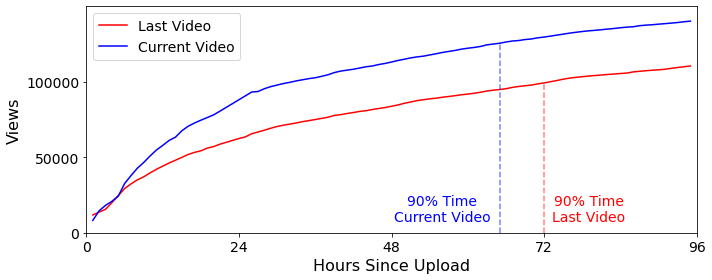

In [196]:
plt.figure(figsize=(10,4))
l1, = plt.plot(np.arange(1,len(orig_views_last)+1), orig_views_last, color='r')
l2, = plt.plot(np.arange(1,len(orig_views)+1), orig_views, color='b')

t_90_last = np.argmin(orig_views_last < orig_views_last.iloc[-1]*.9)
t_90 = np.argmin(orig_views < orig_views.iloc[-1]*.9)

k = 1
plt.plot([t_90_last*k,t_90_last*k], [0,orig_views_last.iloc[-1]*.9], color='red', linestyle='--', alpha=0.5)
plt.plot([t_90*k,t_90*k], [0,orig_views.iloc[-1]*.9], color='blue', linestyle='--', alpha=0.5)

plt.xlabel('Hours Since Upload', fontsize=16)
plt.ylabel('Views', fontsize=16)

plt.xlim(0,96)
plt.yticks(np.arange(0,150000,50000), fontsize=14)
plt.ylim(0, 150000)
plt.xticks(np.arange(0,100,24), fontsize=14)

plt.legend(['Last Video', 'Current Video'], fontsize=14)

plt.annotate('90% Time\nCurrent Video', [56,7500], color='b', fontsize=14, horizontalalignment='center')
plt.annotate('90% Time\nLast Video', [79,7500], color='r', fontsize=14, horizontalalignment='center')

plt.tight_layout()
plt.savefig('last_and_curr_vid_tasty.png')

In [187]:
execute_query('SELECT PublishedDate FROM Videos WHERE VideoID="RLNkCcnTPYM"', True)

[('2020-05-21T19:30:03Z',)]

In [188]:
execute_query('SELECT PublishedDate FROM Videos WHERE VideoID="girpGVZ1U3o"', True)

[('2020-05-18T19:00:11Z',)]